# Language Modeling From Scratch - Deep Dive Into Activations, Gradients and BatchNormalization

In previous article we implemented a Multi Layer Perceptron with 2 Hidden Layers. We observed an improvement over our original model which made use of probability distribution to generate random names. In this article we'll take a deeper look into activations, gradients and batch normalization. This is a separate article in itself because it's important to develop a solid understanding of these topics before we mode onto more complex architectures like RNN and Transformers.

Starting code for this article is same as previous article, just a cleaned out version of it. As usual, we'll start by importing all the required modules.

## Setup

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import numpy as np
%matplotlib inline

Next we'll import our dataset of names and build vocabulary out of it

In [40]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
len(words), vocab_size, itos, stoi

(32033,
 27,
 {1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'},
 {'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0})

Adding a utility method to create train, test and validation dataset

In [41]:
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

Creating training, testing and validation dataset using the above method. We'll use 80%, 10% and 10% respectively

In [42]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Similar to the neural network discussed in previous article, we'll create two hidden layers, HL1 and HL2

![https://cs231n.github.io/assets/nn1/neural_net2.jpeg](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [49]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


Next we'll setup the training loop with forward pass, backward pass and parameter update using learning rate, same as last article. We'll also keep track of loss per step to later plot the results.

In [43]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

def run_training_loop(break_on_first=False):

  for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if break_on_first:
      return logits, h, hpreact
      break

In [45]:
run_training_loop()

      0/ 200000: 29.8979
  10000/ 200000: 2.6601
  20000/ 200000: 2.7236
  30000/ 200000: 2.2986
  40000/ 200000: 2.5010
  50000/ 200000: 2.0478
  60000/ 200000: 2.4736
  70000/ 200000: 2.4584
  80000/ 200000: 2.4450
  90000/ 200000: 2.1317
 100000/ 200000: 2.3553
 110000/ 200000: 2.4058
 120000/ 200000: 1.6513
 130000/ 200000: 1.9658
 140000/ 200000: 2.1240
 150000/ 200000: 2.0506
 160000/ 200000: 2.0208
 170000/ 200000: 2.3377
 180000/ 200000: 2.1702
 190000/ 200000: 2.0824


Adding a method to calculate loss on train and validation split

In [44]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())



In [ ]:
split_loss('train')
split_loss('val')

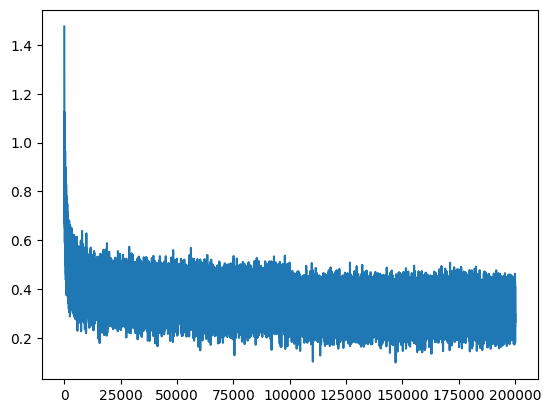

In [47]:
plt.plot(lossi)

Now that we have the initial setup done, let's look into the optimizations that we can perform.

## Overconfident Softmax

The first problem that the above model has is the "hockeystick" nature of loss over time, as is evident from the above graph. During first iteration we are seeing loss of 29.8979, which is way-too-high. 

### What should be the expected loss for first iteration?
For the first iteration, we'd expect the model to have no prediction ability, so it should assign equal probability to each of the character which would be 1/27. Let's look at what the loss corresponding to this value comes out to be.


In [50]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

So the loss reported by the neural network on first iteration should be around 3.29, Let's try to look at what the logits reported by HL2 after first iteration are

In [51]:
# Reinitialize weights and then run the training loop again
logits, _, _ = run_training_loop(break_on_first=True)
logits[0]

      0/ 200000: 29.8979


tensor([ -7.0724,   4.4451,  10.1186,  13.6337,   8.1399,   2.1134,   3.3501,
         12.6121, -10.0490,  -6.7101,  -9.5156, -17.8216,   7.2949,  -1.5835,
         10.2453, -14.9260,  -4.5385, -16.9217,   5.0395, -11.4323,  17.1238,
         12.3386,  16.0655,   0.0758,   1.6998,  28.4674,   6.6073],
       grad_fn=<SelectBackward0>)

As we can see, the logits are diverging a lot, thus making the softmax overconfidently predicit a few character where it should have almost same values for each character. We can solve this problem by multiplying W2 by a constant, say 0.01 which would reduce the value of weights, hence the value of logits reported by (W2 * input + b2), let's look at the logits reported by changing W2 to W2 * 0.0.1

In [70]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


After running the training loop for first iteration, let's check the value of logits again

In [54]:
logits, _, _ = run_training_loop(break_on_first=True)
logits[0]

      0/ 200000: 3.8155


tensor([ 0.5781, -0.8984, -0.1784,  1.5460, -1.6654, -1.3676,  0.2092,  0.8925,
        -1.1660,  0.3242,  0.0055,  0.4046,  1.0528, -0.4510,  0.5271, -0.6357,
         2.5709,  0.9907, -0.1271, -0.9460, -0.7640,  1.0952,  0.0044, -0.3396,
        -1.4397, -0.7380,  1.3038], grad_fn=<SelectBackward0>)

We can see that the values are closer to each other now. Now let's run the entire training loop and check the final reported loss

In [56]:
lossi = []
# reinitialize the weights and run the full training loop again
run_training_loop()

      0/ 200000: 3.8155
  10000/ 200000: 2.1191
  20000/ 200000: 2.6264
  30000/ 200000: 2.1872
  40000/ 200000: 2.4961
  50000/ 200000: 1.8205
  60000/ 200000: 2.1090
  70000/ 200000: 2.3420
  80000/ 200000: 2.3301
  90000/ 200000: 2.0682
 100000/ 200000: 2.2838
 110000/ 200000: 2.2106
 120000/ 200000: 1.6535
 130000/ 200000: 1.8890
 140000/ 200000: 2.0644
 150000/ 200000: 1.9606
 160000/ 200000: 1.9712
 170000/ 200000: 2.3565
 180000/ 200000: 2.0956
 190000/ 200000: 2.1049


train 2.0693342685699463
val 2.1324031352996826


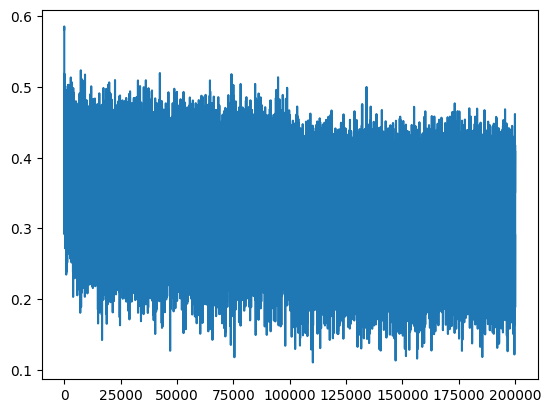

In [57]:
split_loss('train')
split_loss('val')
plt.plot(lossi)

We can make two observations here
- Both training loss and validation loss are lower than previously reported
- The "hockey shape" of the loss over iteration is gone as we are now initializing W2 with more reasonable values resulting in better logits values and softmax not being wrong confidently. 
This also results in model spending more iterations in actually reducing the loss rather than spending those cycles in trying to squash loss from very high values to a more reasonable one.

## TanH Saturation
The plot below shows what a tanh function looks like, as we can see the function acts as a bounding method for the input and limits value in the range of [-1, 1]. For very hight values, tanH value remains constant at 1 and for very low values tanH value remains constant at -1. For both of these scenarios gradiant is 0. This is true for other squashing functions like sigmoid and relu.

In [ ]:
import numpy as np
x = np.linspace(-100, 100, 100)
y = np.tanh(x)
plt.plot(x, y, label='y = tang(x)')

Now let's take a look at the activations from first hidden layer i.e hpreact and the corresponding h values and plot them out to see what values are being used.

In [72]:
logits, h, hpreact = run_training_loop(break_on_first=True)

      0/ 200000: 3.8508


In [74]:
h.shape

torch.Size([32, 200])

(array([2125.,  153.,  117.,   76.,   65.,   51.,   44.,   60.,   20.,
          26.,   17.,   25.,   22.,   30.,   30.,   20.,   28.,   16.,
          19.,   18.,   29.,   24.,   14.,   12.,   25.,   29.,   16.,
          20.,   28.,   21.,   24.,   18.,   14.,   22.,    6.,   38.,
          27.,   29.,   49.,   17.,   22.,   16.,   29.,   44.,   44.,
          39.,  109.,  114.,  174., 2385.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

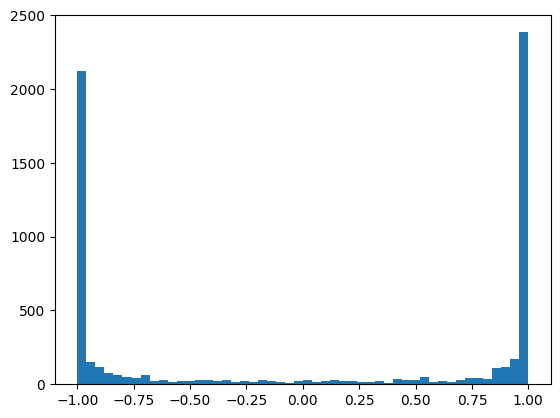

In [77]:
plt.hist(h.view(-1).tolist(), bins=50)

From the above figure we can clearly see that the -1 and 1 values occur most frequently. Which would mean for all of these values when the network backpropagates, there would be no gradiant and associated neuron would not learn anything. Let's check one more thing

Now we'll check how many examples have h > 0.99

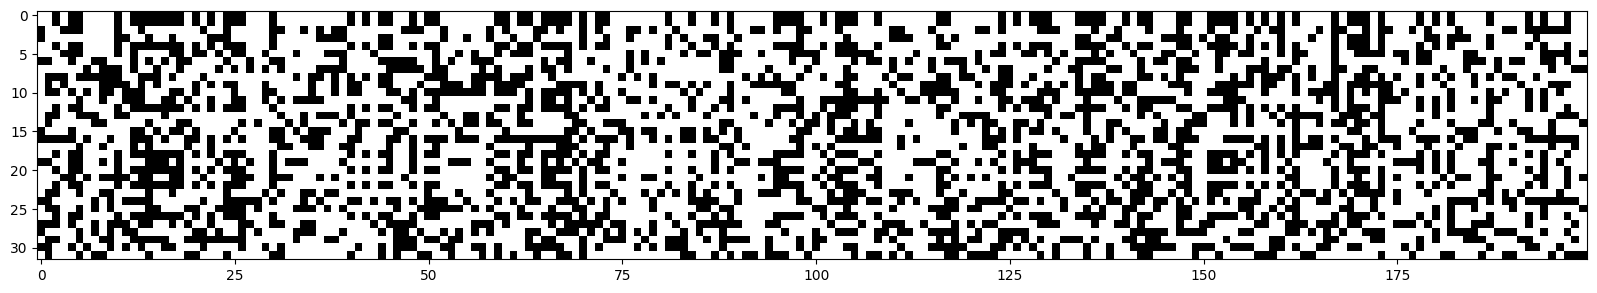

In [78]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') 

With the plot above, we see that a lot of it is white, which means lot of the neurons are in the the flat area of tanh. We would be in a lot of trouble if for any of these neurons we have an entire column white. That would be what we call a "dead neuron".

A dead neuron is a neuron for which none of the examples land in active and non-flat area of tanh. Such a neuron never learns anything from the examples and is the machine learning equivalent of the biological term - "brain dead"

Another interesting thing to note here is that, the neurons can become dead during optimization as well. For instance when learning rate is very high, it can result in preactivation(hpreact) values to tip over to the flat zone, thereby making the neuron dead from that moment onwards.

---

As we have seen the issue arises due to high values of hpreact, so we can make use of the approach we used earlier and decrease the Weights W1.

In [93]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [90]:
logits, h, hpreact = run_training_loop(break_on_first=True)

      0/ 200000: 3.3189


(array([160., 168., 172., 157., 165., 139., 146., 123., 116., 122., 108.,
        105.,  91., 108., 104.,  97., 110.,  83.,  99., 114., 106.,  97.,
         98.,  90., 113., 108., 111., 120., 104.,  93., 104., 130.,  98.,
        117., 108., 118., 109., 109., 121., 106., 133., 126., 140., 161.,
        156., 171., 196., 207., 238., 225.]),
 array([-9.99249458e-01, -9.59265115e-01, -9.19280772e-01, -8.79296429e-01,
        -8.39312086e-01, -7.99327743e-01, -7.59343400e-01, -7.19359057e-01,
        -6.79374714e-01, -6.39390371e-01, -5.99406028e-01, -5.59421685e-01,
        -5.19437342e-01, -4.79452999e-01, -4.39468656e-01, -3.99484313e-01,
        -3.59499969e-01, -3.19515626e-01, -2.79531283e-01, -2.39546940e-01,
        -1.99562597e-01, -1.59578254e-01, -1.19593911e-01, -7.96095681e-02,
        -3.96252251e-02,  3.59117985e-04,  4.03434610e-02,  8.03278041e-02,
         1.20312147e-01,  1.60296490e-01,  2.00280833e-01,  2.40265176e-01,
         2.80249519e-01,  3.20233862e-01,  3.60218

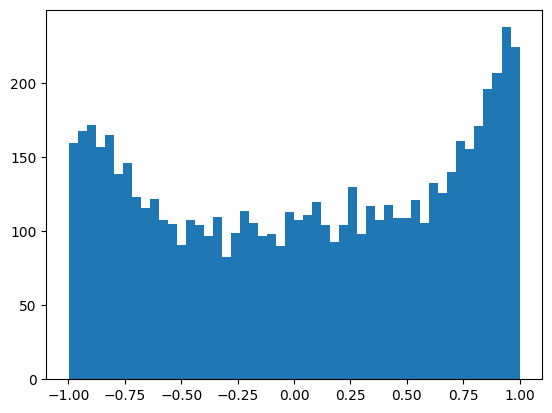

In [91]:
plt.hist(h.view(-1).tolist(), bins=50)

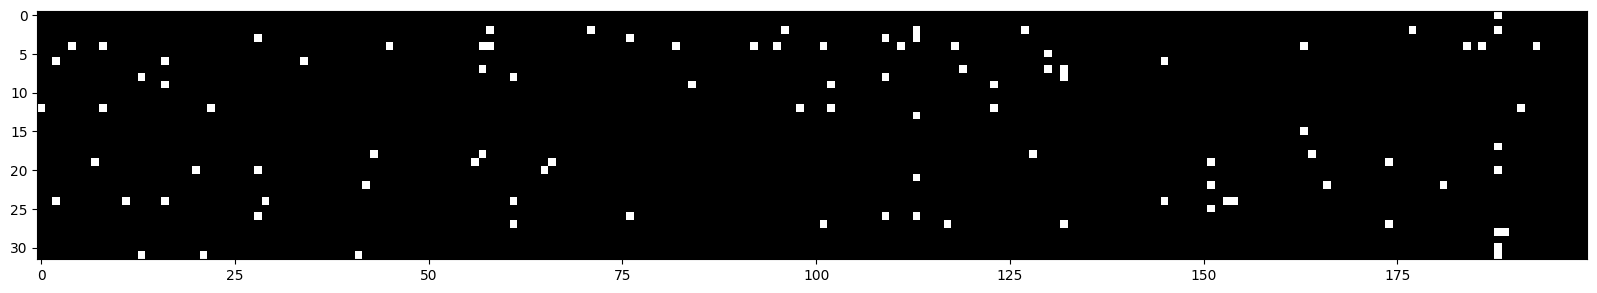

In [92]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') 

So what we did above is essentially decrease the value of preactivations such that the values fall in the non-flat region of tanh. The image above shows that very few of the neurons are activated with the examples for the first iteration. Let's try to use this approach for the entire training set

In [87]:
run_training_loop()

      0/ 200000: 3.3189
  10000/ 200000: 2.0652
  20000/ 200000: 2.5255
  30000/ 200000: 2.0096
  40000/ 200000: 2.2400
  50000/ 200000: 1.8046
  60000/ 200000: 2.0230
  70000/ 200000: 2.2471
  80000/ 200000: 2.3160
  90000/ 200000: 2.1416
 100000/ 200000: 2.1507
 110000/ 200000: 2.1757
 120000/ 200000: 1.5639
 130000/ 200000: 1.8486
 140000/ 200000: 2.1428
 150000/ 200000: 1.9197
 160000/ 200000: 2.0423
 170000/ 200000: 2.3999
 180000/ 200000: 2.0102
 190000/ 200000: 2.0702


train 2.0361340045928955
val 2.102936267852783


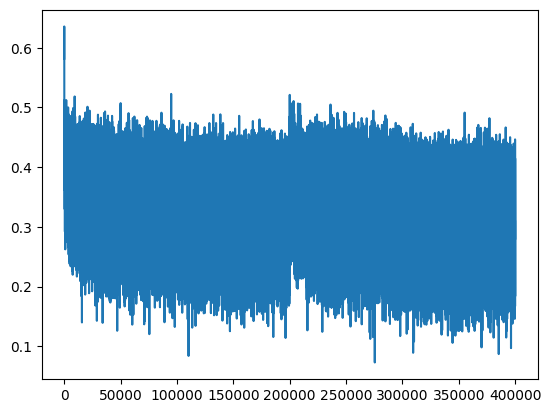

In [88]:
split_loss('train')
split_loss('val')
plt.plot(lossi)

Summarizing the results so far

- Initial results
```
train 2.135850667953491
val 2.1770708560943604
```

- Results after softmax fix
```
train 2.0693342685699463
val 2.1324031352996826
```

- Results after tanh fix
```
train 2.0361340045928955
val 2.102936267852783
```

We've managed to improve the results to a validation loss of 2.109.

## Autocalculating the scale-down factor

In the example above we use 0.2 to scale down W1, this might seem random and it is. To make use of a semi-principled approach, let's look into how much we need to scale down W1 with an example



tensor(0.0082) tensor(0.9978) tensor(-0.0081) tensor(3.2544)


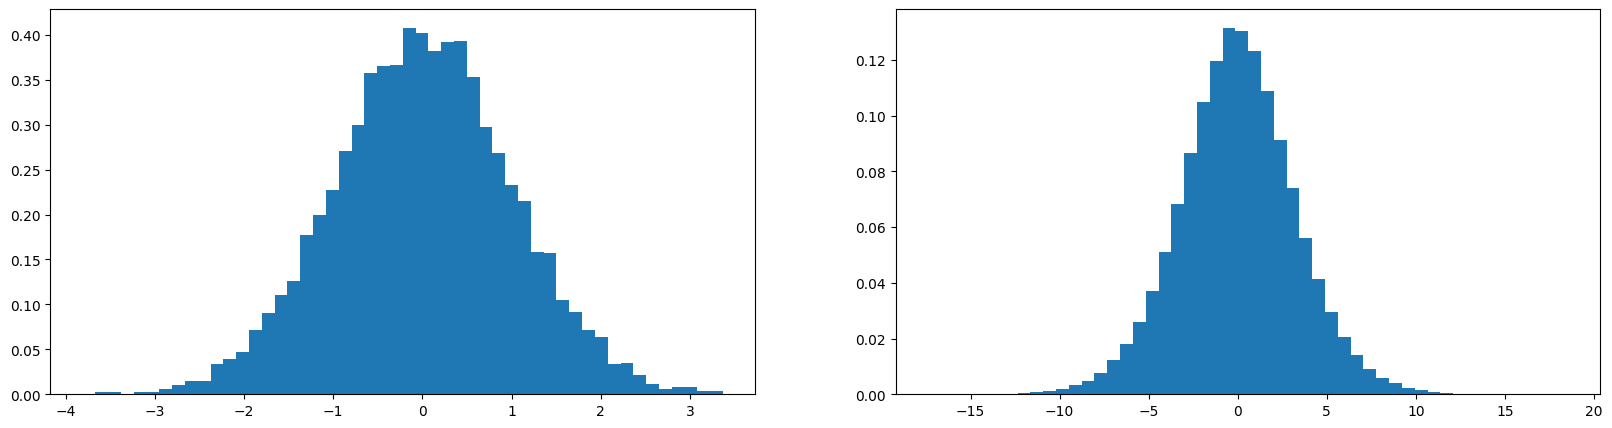

In [5]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) 
y = x @ w
print(x.mean(), x.std(), y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);



The figure on left shows `x` with std 0.9978 and figure on right shows `y` with std 3.2554. `y` takes on more extreme values. Let's see what happens when we multiply x by 0.2

tensor(0.0256) tensor(1.0056) tensor(-0.0015) tensor(0.6493)


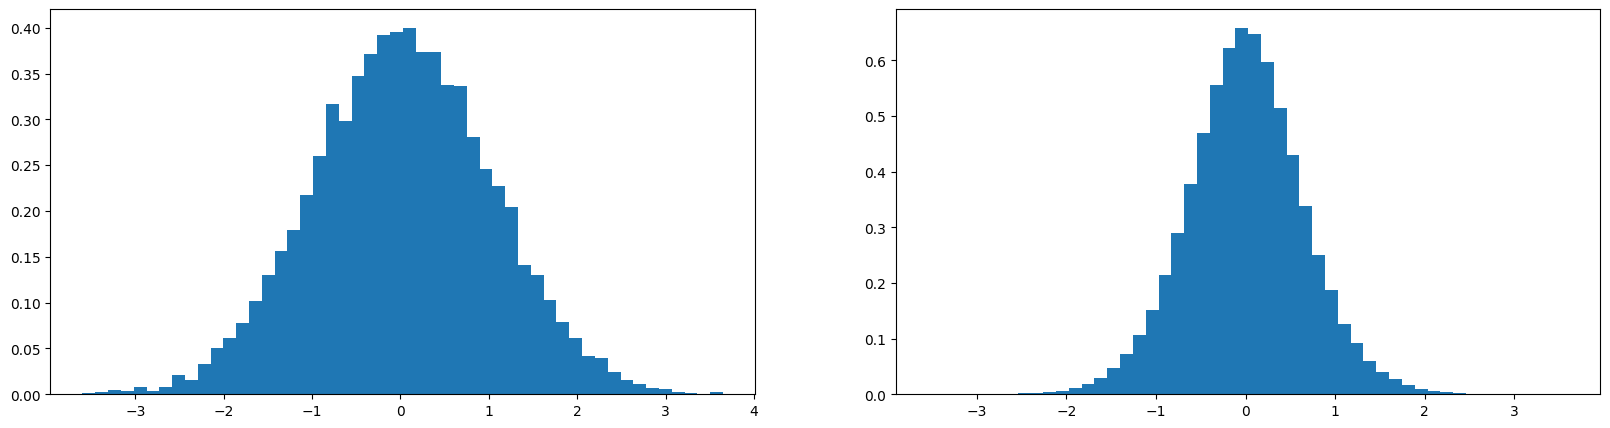

In [7]:

x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * 0.2
y = x @ w
print(x.mean(), x.std(), y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

y now has std of 0.6493 and takes on less extreme values. 

Based on the discussion in section TanH saturation, we know that we want preactivation values to be in range of 1 and -1, so we want the standar deviation of y same as that of x. Based on mathematical calculations that number comes out be 1/(sqrt(fan_in)) where fan_in is the number of inputs to the layer. Let's test this theory

tensor(0.0028) tensor(1.0039) tensor(0.0020) tensor(1.0034)


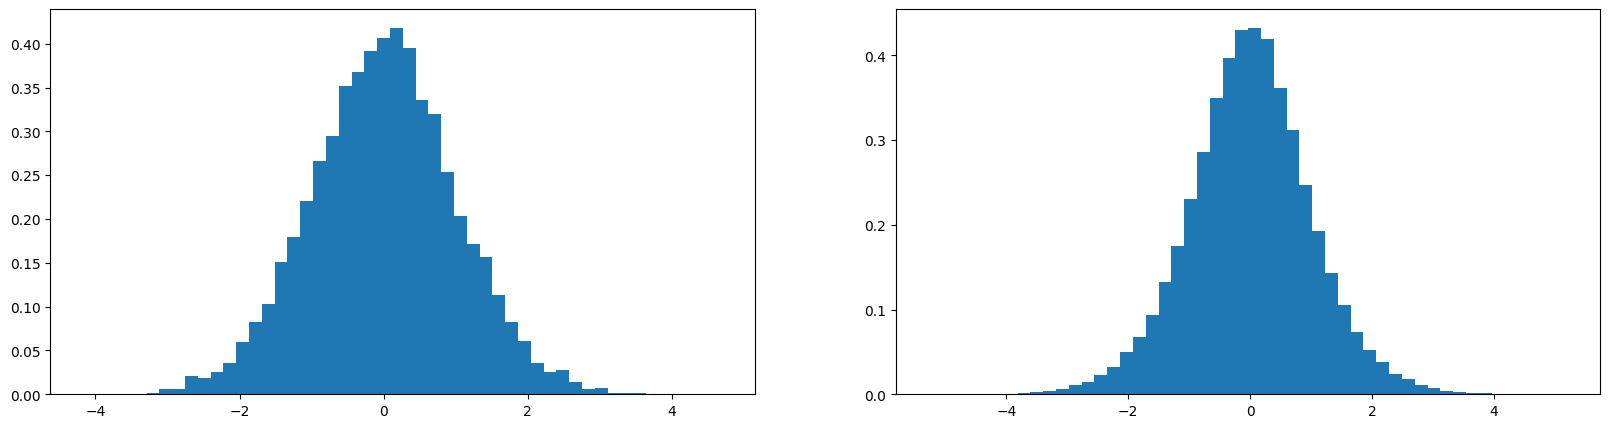

In [36]:
x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * 1/(10 ** 0.5)
y = x @ w
print(x.mean(), x.std(), y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

The std of y is now roughly 1 and this is what we want while training our neural network. One paper that has delved deep into this topic and is often cited is [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)

The paper discusses Relu and leaky Relu instead of tanh but the conclusion applied to both since both of them are squashing functions
![https://pub.mdpi-res.com/sensors/sensors-23-04072/article_deploy/html/images/sensors-23-04072-g001.png?1681810532](https://pub.mdpi-res.com/sensors/sensors-23-04072/article_deploy/html/images/sensors-23-04072-g001.png?1681810532)

The paper concludes that since Relu clamps the input which is less than 0 and only allows input > 0 to "pass through", we need a gain factor of 2/sqrt(fan_in) to compensate for that. They also discuss that by adding this gain factor the backpropagation is also taken care of and we don't need to perform any additional scaling to control gradients.

## Kaiming Initialization

Pytorch has an implementation of the methods discussed in above paper in [kaiming.init_normal](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) and it provides 5/3 * (1/sqrt(fan_in)) as the scale_down factor of w. let's use it with our example


tensor(-0.0036) tensor(1.0131) tensor(-0.0065) tensor(1.6528)


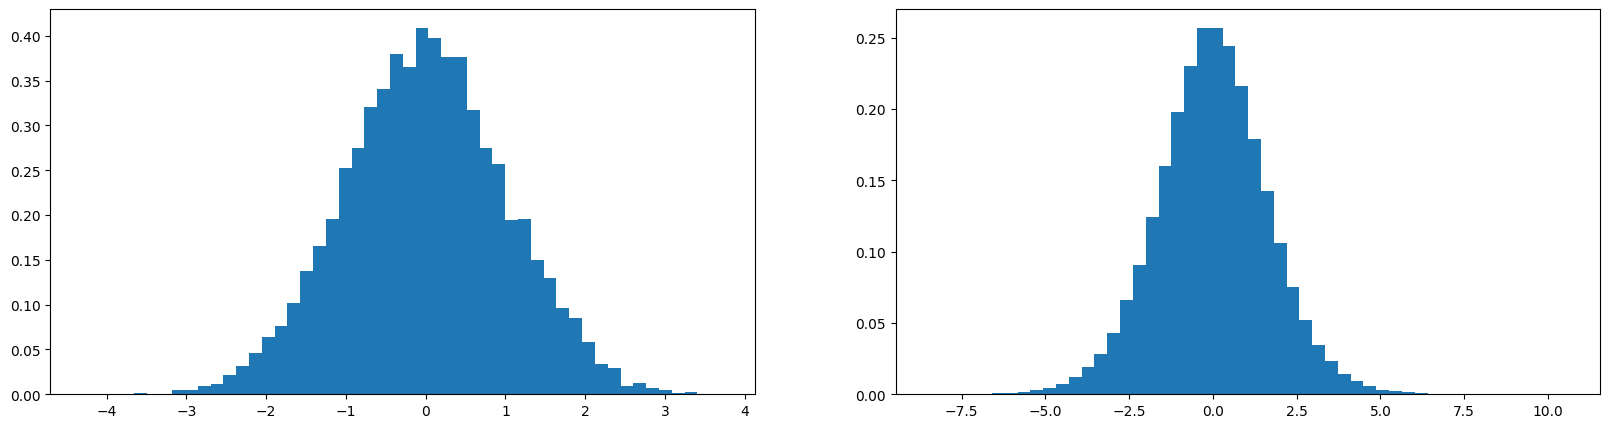

In [37]:
x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * (5/3.0)/((10 ** 0.5))
y = x @ w
print(x.mean(), x.std(), y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

Using this modification in our weight initialization now and running training loop again

In [45]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3.0)/((n_embd * block_size) ** 0.5)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [46]:
run_training_loop()

      0/ 200000: 3.8202
  10000/ 200000: 2.0395
  20000/ 200000: 2.5593
  30000/ 200000: 2.0449
  40000/ 200000: 2.3927
  50000/ 200000: 1.8230
  60000/ 200000: 2.0606
  70000/ 200000: 2.3983
  80000/ 200000: 2.2355
  90000/ 200000: 2.0813
 100000/ 200000: 2.1729
 110000/ 200000: 2.3369
 120000/ 200000: 1.6170
 130000/ 200000: 1.8658
 140000/ 200000: 2.0709
 150000/ 200000: 2.0079
 160000/ 200000: 1.9552
 170000/ 200000: 2.4202
 180000/ 200000: 2.0596
 190000/ 200000: 2.1027


train 2.0395455360412598
val 2.1068387031555176


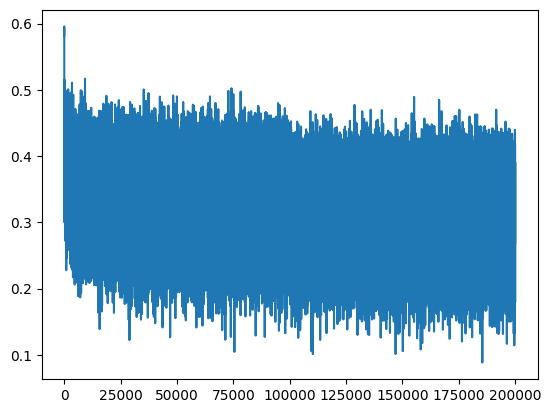

In [47]:
split_loss('train')
split_loss('val')
plt.plot(lossi)

Summarizing the results so far

- Initial results
```
train 2.135850667953491
val 2.1770708560943604
```

- Results after softmax fix
```
train 2.0693342685699463
val 2.1324031352996826
```

- Results after tanh fix
```
train 2.0361340045928955
val 2.102936267852783
```

- Results with kaiming init
```
train 2.0395455360412598
val 2.1068387031555176
```

We can see that we arrive at roughly the same position as after tanh fix, but without using magic number for scaling down W1.

These optimization we very crucial in early years of neural networks, but not so much today. Today with techniques like Batch normalization, it's not as crucial to initialize neural network perfectly as it was earlier. Let's take a look into why that's the case

## Batch Normalization

Batch normalization was introduced by [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). This was a very significant paper as it allows us to train large neural networks
The core insight from the paper was to normalize the hidden state to be gaussian. Since we already know that we want the preactivations to lie within [-1,1] for tanh function to be active, we can directly attempt to normalize the preactivations to be roughly guassian. Mathematically this looks like
(hpreact - h.mean())/h.std()

All the operations involved in the above expressions are differentiable, we can just use this expressions for forward pass and calculate its derivative during backward pass.

One thing to note here, is that we only want to force preactivations to be guassian during first ietrations and allow enough flexibility to be updated during backpropagation. For this we'll make use of scale and shift as mentioned in the paper above. Let's re-initialize the training and testing loop

In [57]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) 

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) # scale
bnbias = torch.zeros((1, n_hidden)) # shift

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [58]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

def run_training_loop(break_on_first=False):

  for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

    hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True))/(hpreact.std(dim=0, keepdim=True)) * bngain + bnbias

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if break_on_first:
      return logits, h, hpreact
      break

In [59]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True))/(hpreact.std(dim=0, keepdim=True)) * bngain + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

Now let's train the model again

In [60]:
run_training_loop()

      0/ 200000: 3.8443
  10000/ 200000: 2.0775
  20000/ 200000: 2.7031
  30000/ 200000: 2.1059
  40000/ 200000: 2.2516
  50000/ 200000: 1.9634
  60000/ 200000: 2.1270
  70000/ 200000: 2.3852
  80000/ 200000: 2.5304
  90000/ 200000: 2.1849
 100000/ 200000: 2.2979
 110000/ 200000: 2.3865
 120000/ 200000: 1.6278
 130000/ 200000: 2.0458
 140000/ 200000: 2.4157
 150000/ 200000: 2.0811
 160000/ 200000: 2.0468
 170000/ 200000: 2.4009
 180000/ 200000: 2.1332
 190000/ 200000: 2.1841


train 2.1137709617614746
val 2.1398322582244873


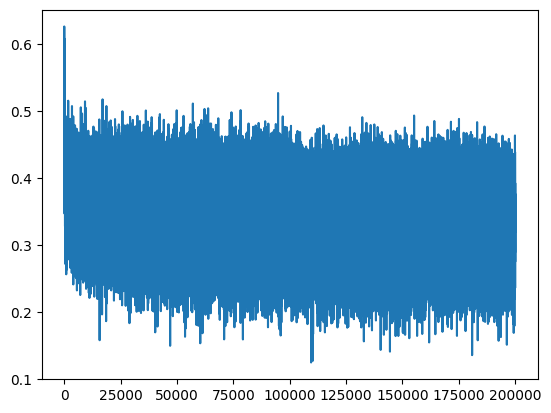

In [61]:
split_loss('train')
split_loss('val')
plt.plot(lossi)

## Conclusion

Let's look at the results so far

- Initial results
```
train 2.135850667953491
val 2.1770708560943604
```

- Results after softmax fix
```
train 2.0693342685699463
val 2.1324031352996826
```

- Results after tanh fix
```
train 2.0361340045928955
val 2.102936267852783
```

- Results with kaiming init
```
train 2.0395455360412598
val 2.1068387031555176
```

- Results with batch norm
```
train 2.1137709617614746
val 2.1398322582244873
```

The results obtained using batch norm are comparable to the other results, but we don't see any improvements. This is to be expected for such a simple neural network with essentially a single hidden layer. We were able to manually calculate the scale down factor of W1 which performs better than batch norm. but that would be tedious and difficult to do in a neural network with 100s of hidden layers and that's where the batch norm really shines.

For larger neural networks it is customary to take a hidden layer and append a batch normalization layer on top of that to control the preactivations at every point of neural network.

Another interesting thing about batch norm is that now our logits and hidden state activations are not just the function of input example but also function of other examples of in that batch. What this does is that it adds a bit of entropy to the example and acts as a form of "data augmentation" which makes it harder for neural network to overfit to the example.